## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [242]:
data = pd.read_csv('ab_data_tourist.zip')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [243]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


Наша таблица занимает **11.2 MB**. Немного оптимизируем данные чтобы они занимали меньше памяти.

Столбец **purchase** может принимать только два значения 0 и 1, его можно преобразовать к типу **np.int8**

In [244]:
data['purchase'] = np.int8(data['purchase'])

Столбцы user_id и price тоже можно оптимизировать, но сначала нужно узнать их максимальные значения

In [245]:
print(f'user_id min {data["user_id"].min()}, max {data["user_id"].max()}')
print(f'price min {data["price"].min()}, max {data["price"].max()}')


user_id min 630000, max 945999
price min 0, max 200000


Оба столбца можно преобразовать к **np.int32**

In [246]:
data['user_id'] = np.int32(data['user_id'])
data['price'] = np.int32(data['price'])

Убедимся что min/max в этих столбцах не поменялсь после преобразования

In [247]:
print(f'user_id min {data["user_id"].min()}, max {data["user_id"].max()}')
print(f'price min {data["price"].min()}, max {data["price"].max()}')


user_id min 630000, max 945999
price min 0, max 200000


Отлично. Проверим сколько памяти нам удалось сэкономить:

In [248]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int32 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int8  
 4   price     294478 non-null  int32 
dtypes: int32(2), int8(1), object(2)
memory usage: 7.0+ MB


Нам удалось сократить объем памяти примерно на треть.

## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [249]:
data['date'] = pd.to_datetime(data['date'])

data.groupby('group').agg({'date': ['min', 'max']})

date           
             min        max
group                      
A     2021-01-02 2021-01-24
B     2021-01-02 2021-01-24

## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [250]:
data2 = data.groupby('group').agg({'user_id': 'count', 'purchase': 'sum', 'price': 'sum'})

data2['price'] = data2['price'] / 1000000

data2.rename(columns={'user_id': 'Кол-во посещений', 'purchase': 'Суммарное кол-во покупок', 'price': 'Сумма всех покупок (млн. руб)'})

,Кол-во посещений,Суммарное кол-во покупок,Сумма всех покупок (млн. руб)
group,,,
A,147202,17723.0,1436.26
B,147276,17514.0,1554.10


## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [251]:
mask_a = data['group'] == 'A'
mask_b = data['group'] == 'B'

set_a = set(data[mask_a]['user_id'].values)
set_b = set(data[mask_b]['user_id'].values)

set_ab = set_a.intersection(set_b)

print(f'Кол-во пользователей попавших в обе группы {len(set_ab)}')

Кол-во пользователей попавших в обе группы 1895


## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [252]:
# updated_data = data[data['user_id'].apply(lambda x: x not in user_intersection)]

# Способ выше плох тем что не позволяет заранее узнать сколько пользователей
# будет убрано из данных. Мы воспользуемся маской для фильтрации пользователей 
# попавших в обе группы. 
mask_ab_users = data['user_id'].isin(set_ab)

print(f'В маске {mask_ab_users.sum()} строк')

В маске 3790 строк


Все правильно, ведь на каждого из 1985 пользователей попавших в обе группы имеется две строки в нашем датаферйме:

1985 * 2 = 3790

Получаем обновленный датафрейм

In [253]:
mask_not_ab_users = ~mask_ab_users

updated_data = data[mask_not_ab_users]

print(f'Строк было {data.shape[0]}')
print(f'Строк стало {updated_data.shape[0]}')
print(f'Разница {data.shape[0] - updated_data.shape[0]} строк')


Строк было 294478
Строк стало 290688
Разница 3790 строк


## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:


|group|count_visits|count_purchases|sum_price|
|-|-|-|-|
|A|?|?|?|
|B|?|?|?| 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?

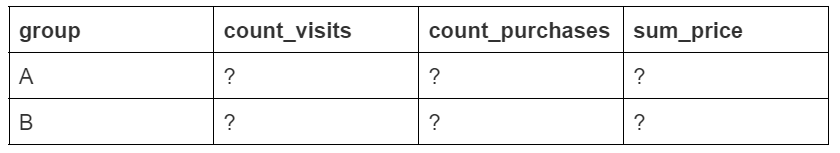

In [254]:
updated_data_summary = updated_data.groupby('group').agg({
    'user_id': 'count',
    'purchase': 'sum',
    'price': 'sum'
})

updated_data_summary.rename(columns={
    'user_id': 'count_visits',
    'purchase': 'count_purchases',
    'price': 'sum_price'
}, inplace=True)

updated_data_summary

,count_visits,count_purchases,sum_price
group,,,
A,145307,17487.0,1417780000
B,145381,17290.0,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

### Вывод

Количество посещений вариантов А и В не одинаково. Но поскольку отличие составляет менее 0.1%, то можно считать его несущественным

In [255]:
prc = (145381 - 145307) / (145381) * 100

print(f'Кол-во посещений варианта А на {prc:0.2}% меньше чем варианта В')

Кол-во посещений варианта А на 0.051% меньше чем варианта В


## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [256]:
smry = updated_data_summary # создадим алиас

smry['conversion'] = smry.apply(lambda x: round(x['count_purchases'] * 100.0 / x['count_visits'], 2), axis=1)
smry['mean_check'] = smry.apply(lambda x: round(x['sum_price'] / x['count_purchases']), axis=1)

updated_data_summary

,count_visits,count_purchases,sum_price,conversion,mean_check
group,,,,,
A,145307,17487.0,1417780000,12.03,81076
B,145381,17290.0,1533010000,11.89,88665


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

### Вывод

Предварительно мы можем отметить, что конверсия покупки незначительно (в пределах статической погрешности) выше у варианта А, тогда как средний чек примерно на 8% выше у варианта B.

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [257]:
purchase_mask = updated_data['purchase'] == 1

purchases_per_tour = updated_data[purchase_mask].groupby(
    ['group', 'price']
).agg({
    'user_id': 'count'
}).reset_index()

purchases_per_tour_pvt = purchases_per_tour.pivot(index='group', columns='price', values='user_id')

purchases_per_tour_pvt

price,10000,60000,100000,150000,200000
group,,,,,
A,5182,5271,1832,3478,1724
B,5201,1730,5227,3438,1694


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

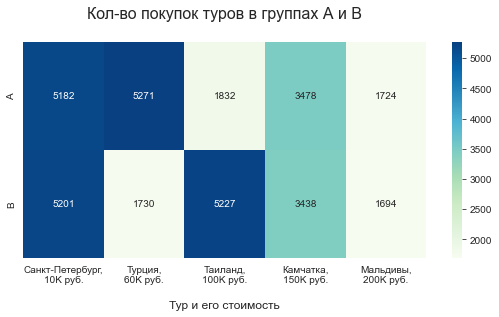

In [305]:
def figax(name, figsize=(7, 4), rowcol=None, axes=[0,0,1,1]):
    fig = plt.figure(name, figsize=figsize)
    
    if rowcol is None:
        ax = fig.add_axes(axes)
    else:
        rows, cols = rowcol
        ax = fig.subplots(rows, cols)

    return fig, ax


fig, ax = figax('grp_tour_htmp', figsize=(7, 3))

sns.heatmap(ax=ax, data=purchases_per_tour_pvt, annot=True, cmap='GnBu', fmt='d')

def map_tour(price):
    if price == 100000:
        return 'Таиланд'
    if price == 60000:
        return 'Турция'
    if price == 200000:
        return 'Мальдивы'
    if price == 10000:
        return 'Санкт-Петербург'
    if price == 150000:
        return 'Камчатка'

ax.set_title('Кол-во покупок туров в группах А и B\n', fontsize=16)
ax.set_xlabel('\nТур и его стоимость', fontsize=12)
ax.set_ylabel('')

tour_prices = [int(x.get_text()) for x in ax.get_xticklabels()]
tour_names = [f'{map_tour(x)},\n{round(x/1000)}K руб.' for x in tour_prices]
ax.set_xticklabels(tour_names);


Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

### Вывод

Судя по диаграмме, предпочтения пользователей из обеих групп оказались очень похожи, за исключением двух туров: Турция и Таиланд. Пользователи из группы А выбирали тур в Турцию примерно в три раза чаще чем тур в Таиланд, а пользователи из группы B наоборот — примерно в три раза чаще выбирали тур в Таиланд, чем тур в Турцию.

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [259]:
data_by_date = updated_data.groupby(['date', 'group']).agg({
    'user_id': 'count',
    'purchase': 'sum',
    'price': 'sum'
}).reset_index().rename(columns={
    'user_id': 'count_visits',
    'purchase': 'count_purchases',
    'price': 'sum_price'
})

data_by_date['conversion'] = data_by_date['count_purchases'] / data_by_date['count_visits']
data_by_date['mean_check'] = data_by_date['sum_price'] / data_by_date['count_purchases']

In [260]:
date_mask = data_by_date['date'] == '2021-01-03'

data_jan_3 = data_by_date[date_mask][['group', 'conversion', 'mean_check']]

data_jan_3['conversion'] = data_jan_3['conversion'].apply(lambda x: round(x * 100, 2))

data_jan_3['mean_check'] = data_jan_3['mean_check'].apply(lambda x: round(x))

data_jan_3

,group,conversion,mean_check
2,A,11.34,82888
3,B,11.39,87480


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [263]:
data_by_date.sort_values('date', inplace=True)

mask_a = data_by_date['group'] == 'A'
mask_b = data_by_date['group'] == 'B'

def calc_cum_params(data, mask):
    data_cp = data.copy()

    data_cp.loc[mask, 'cum_visits'] = data_cp[mask]['count_visits'].cumsum()
    data_cp.loc[mask, 'cum_purchases'] = data_cp[mask]['count_purchases'].cumsum()
    data_cp.loc[mask, 'cum_price'] = data_cp[mask]['sum_price'].cumsum()
    data_cp.loc[mask, 'cum_conversion'] = data_cp[mask]['cum_purchases'] / data_cp[mask]['cum_visits']
    data_cp.loc[mask, 'cum_mean_check'] = data_cp[mask]['cum_price'] / data_cp[mask]['cum_purchases']

    return data_cp

data_by_date = calc_cum_params(data_by_date, mask_a)
data_by_date = calc_cum_params(data_by_date, mask_b)

# Какая кумулятивная конверсия была в группе B на 20 января? 
# Ответ приведите в процентах, округлив до сотых.

mask_jan_20 = data_by_date['date'] == '2021-01-20'
data_grp_b_jan_20 = data_by_date[mask_b & mask_jan_20]
cum_conversion_grp_b_jan_20 = data_grp_b_jan_20['cum_conversion'].values[0]
print(f'Куммулятивная конверсия в группе B на 20 января: {round(cum_conversion_grp_b_jan_20 * 100, 2)}')

# Какой кумулятивный средний чек был в группе А на 12 января 2021 года?
# Ответ приведите в рублях, округлив до целых.

mask_jan_12 = data_by_date['date'] == '2021-01-12'
data_grp_a_jan_12 = data_by_date[mask_a & mask_jan_12]
cum_mean_check_grp_a_jan_12 = data_grp_a_jan_12['cum_mean_check'].values[0]
print(f'Куммулятивный средний чек в группе A на 12 января: {round(cum_mean_check_grp_a_jan_12)}')

Куммулятивная конверсия в группе B на 20 января: 11.9
Куммулятивный средний чек в группе A на 12 января: 81492


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

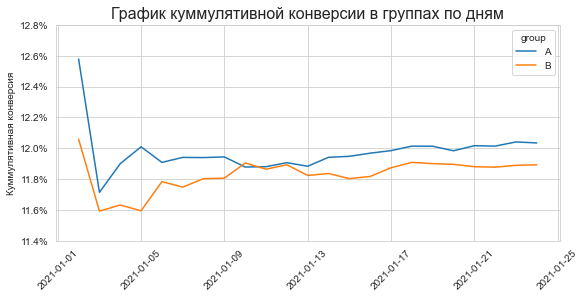

In [319]:
sns.set_style("whitegrid")
colors = sns.color_palette('husl', 9)[1:]

fig, ax = figax('grp_cum_conv', figsize=(7, 3))

sns.lineplot(
    data=data_by_date,
    x='date',
    y='cum_conversion',
    hue='group', 
    ax=ax
)

ax.set_title('График куммулятивной конверсии в группах по дням', fontsize=16)
ax.set_xlabel('')
ax.set_ylabel('Куммулятивная конверсия')
ax.set_yticks([x/1000 for x in range(114, 130, 2)])
ax.set_yticklabels([f'{x * 100:.1f}%' for x in ax.get_yticks()])
ax.xaxis.set_tick_params(rotation=45);

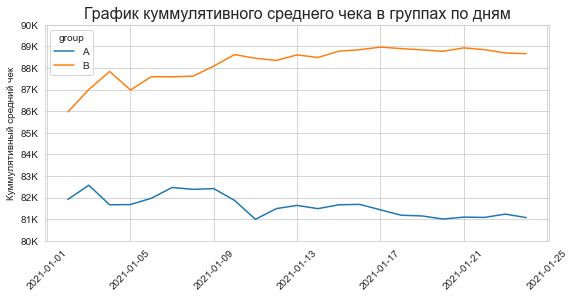

In [326]:
fig, ax = figax('grp_cum_chck', figsize=(7, 3))

sns.lineplot(
    data=data_by_date,
    x='date',
    y='cum_mean_check',
    hue='group', 
    ax=ax
)

ax.set_title('График куммулятивного среднего чека в группах по дням', fontsize=16)
ax.set_xlabel('')
ax.set_ylabel('Куммулятивный средний чек')
ax.set_yticks([x * 1000 for x in range(80, 91)])
ax.set_yticklabels([f'{x/1000:.0f}K' for x in ax.get_yticks()])
ax.xaxis.set_tick_params(rotation=45);

ваши выводы здесь

#### Вывод

На обоих графиках мы наблюдаем примерно одинаковую картину — в начале графики нестабильны, но постепенно линии выравниваются, и начиная с 18 января метрики стабилизируются. Тест можно считать завершенным.

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

Для начала попробуем визуально оценить конверсию в группах с помощью коробчатой диаграммы.

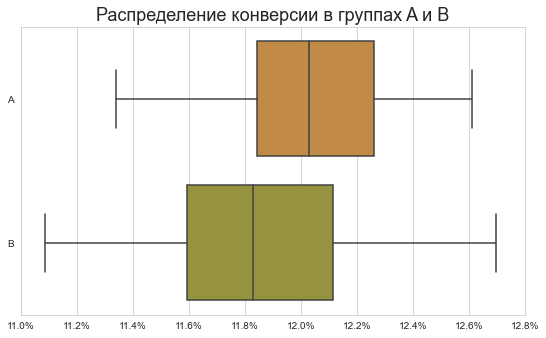

In [362]:
fig, ax = figax('conv-ab-box')

sns.boxplot(ax=ax, data=data_by_date, x='conversion', y='group', palette=colors)

ax.set_title('Распределение конверсии в группах A и B', fontsize=18)
ax.set_xlabel('')
ax.set_xticks([x / 1000 for x in range(110, 130, 2)])
ax.set_xticklabels([f'{round(x * 100, 1)}%' for x in ax.get_xticks()])
ax.set_ylabel('');

На диаграмме видно, что конверсия в группе A немного выше.

Чтобы судить о значимости этого отличия нам нужно применить статистический тест. Проведем z-тест для пропорций.

In [366]:
proportions_data = data_by_date.groupby('group').agg({
    'count_visits': 'sum',
    'count_purchases': 'sum'
})

H0 = 'Конверсии в группах A и B равны'
Ha = 'Конверсия в группе A больше чем конверсия в группе B'
alpha = 0.05

_, p = proportions_ztest(
    count=proportions_data['count_purchases'],
    nobs=proportions_data['count_visits'],
    alternative='larger'
)

print(f'P-value = {round(p, 2)}')

if p > alpha:
    print('P-value > alpha, следовательно мы не можем отвергнуть нулевую гипотезу.')
else:
    print('P-value < alpha, следовательно мы отвергаем нулевую гипотезу.')

P-value = 0.12
P-value > alpha, следовательно мы не можем отвергнуть нулевую гипотезу.


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

#### Вывод

Не смотря на то, что конверсия в группе A номинально выше, чем в группе B, мы можем с 95% вероятностью утверждать, что статистической значимости эта разница не имеет. 

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [370]:
updated_data.head()


,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


In [376]:
def conf_interval(gamma, xp, n):
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp * (1 - xp) / n) ** 0.5 #погрешность
    lower_bound = xp - eps # левая (нижняя) граница
    upper_bound = xp + eps # правая (верхняя) граница
    
    return (round(lower_bound * 100, 2), round(upper_bound * 100, 2))

def print_conf_interval(group):
    mask = updated_data['group'] == group
    n = updated_data[mask]['purchase'].count()
    xp = updated_data[mask]['purchase'].sum() / n

    lb, ub = conf_interval(0.95, xp, n)
    print(f'95% доверительный интервал конверсии для группы {group}')
    print(f'от {lb}% до {ub}%\n')

print_conf_interval('A')
print_conf_interval('B')

95% доверительный интервал конверсии для группы A
от 11.87% до 12.2%

95% доверительный интервал конверсии для группы B
от 11.73% до 12.06%



In [388]:
def diff_proportions_conf_interval(n, xp, gamma):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

prop_data = updated_data.groupby('group').agg({
    'user_id': 'count',
    'purchase': 'sum',
}).rename(columns={'user_id': 'n'})

prop_data['conversion'] = prop_data['purchase'] / prop_data['n']

lb, ub = diff_proportions_conf_interval(prop_data['n'], prop_data['conversion'], 0.95)

print('Доверительный интервал разницы конверсий групп A и B лежит в пределах')
print(f'от {lb}% до {ub}%')

Доверительный интервал разницы конверсий групп A и B лежит в пределах
от -0.38% до 0.09%


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

#### Вывод

Доверительные интервалы конверсии групп A и B перекрываются на большем своем протяжении (с 11.27% до 12.06%). Это значит, что истинное значение конверсии обеих групп может находиться в этом интервале и даже совпасть.

Доверительный интервал разницы конверсий проходит через ноль. То есть разница может быть как положительной, так и отрицательной. Следовательно мы не можем утверждать, что одна из конверсий больше другой. Таким образом с высокой долей вероятности мы можем утверждать, что метрики конверсии в группах A и B одинаковы.

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

Прежде всего построим гистограммы ежедневного среднего чека, чтобы оценить распределение визуально.

Для построения гистограмм использовано значений 23


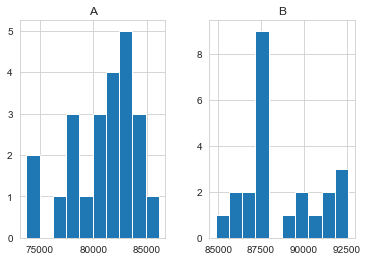

In [399]:
data_by_date_pvt = data_by_date.pivot(index='date', columns='group', values='mean_check')
data_by_date_pvt.hist();

print(f'Для построения гистограмм использовано значений {data_by_date_pvt.shape[0]}')

Распределение похоже на нормальное. Для его построения было использовано всего 23 значения. Если бы их было в 5-10 раз больше, то гистограммы были больше похожи на колокол.

Теперь применим тест Шапиро-Уилка. Этот тест хорошо работает для выборок небольшого размера.

In [401]:
H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально'

alpha = 0.05

def test_normal_distribution(group):
    print(f'Проверка нормального распределения для группы "{group}"')

    data = data_by_date[data_by_date['group'] ==  group]['mean_check']

    _, p = shapiro(data)

    print(f'P-value = {p:.3f}')

    if p > alpha:
        print(H0)
    else:
        print(Ha)


test_normal_distribution('A')
print('')
test_normal_distribution('B')

Проверка нормального распределения для группы "A"
P-value = 0.253
Данные распределены нормально

Проверка нормального распределения для группы "B"
P-value = 0.094
Данные распределены нормально


## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [ ]:
# ваш код здесь

 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

In [ ]:
ваши выводы здесь

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [ ]:
# ваш код здесь

Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

In [ ]:
ваши выводы здесь

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 